Calculate RayTransfer Matrix (RTM) with PHiX Fast Camera
===
To show the RTM values, we calculate a certain pixel's RTM.

In [1]:
import datetime
from pathlib import Path
from textwrap import dedent

import numpy as np
from cherab.tools.raytransfer import RayTransferPipeline2D
from matplotlib import pyplot as plt
from raysect.core.scenegraph import print_scenegraph
from raysect.optical import World
from raysect.optical.observer import FullFrameSampler2D

from cherab.phix.machine import import_phix_mesh
from cherab.phix.observer import import_phix_camera
from cherab.phix.plasma import import_equilibrium
from cherab.phix.tools import profile_1D_to_2D
from cherab.phix.tools.raytransfer import import_phix_rtc
from cherab.phix.tools.visualize import show_phix_profiles

Create scene world
---

In [2]:
# generate scene world
world = World()

# import phix equilibrium
eq = import_equilibrium()

# import phix machine configuration
mesh = import_phix_mesh(world, reflection=True)

# import phix raytrasfer cylinder object
rtc = import_phix_rtc(world, equilibrium=eq)

# import phix camera
camera = import_phix_camera(world)

✅ Vaccum Vessel: RoughSUS316L (roughness: 0.0125)
✅ Vacuum Flange: RoughSUS316L (roughness: 0.0125)
✅ Magnetron Port: RoughSUS316L (roughness: 0.0125)
✅ Limiter Box: RoughSUS316L (roughness: 0.2500)
✅ Limiter 225: RoughSUS316L (roughness: 0.2500)
✅ Flux Loop: RoughSUS316L (roughness: 0.2500)
✅ Feed Back Coil (upper): RoughSUS316L (roughness: 0.2500)
✅ Feed Back Coil (lower): RoughSUS316L (roughness: 0.2500)
✅ Rail (upper): RoughSUS316L (roughness: 0.2500)
✅ Rail (lower): RoughSUS316L (roughness: 0.2500)
✅ Rail Connection: PCTFE
✅ Vacuum Vessel Gasket: PCTFE
✅ importing PHiX camera...


Define Observer pipeline
---

In [3]:
rtp = RayTransferPipeline2D(name="rtm")

# set camera's pipeline property
camera.pipelines = [rtp]

Set camera parameters
---
To focus one pixel, the `mask` array is defined.

In [4]:
focus_pixel = (100, 400)
mask = np.zeros(camera.pixels, dtype=bool)
mask[focus_pixel[0] - 1, focus_pixel[1] - 1] = True

Set the number of pixel and lens samples as $N_\text{pixel} = 5$, $N_\text{lens} = 5$

In [5]:
camera.frame_sampler = FullFrameSampler2D(mask=mask)
camera.min_wavelength = 655.6
camera.max_wavelength = 656.8
camera.spectral_rays = 1
camera.spectral_bins = rtc.bins
camera.per_pixel_samples = 5
camera.lens_samples = 5

Execute ray-tracing
---

In [6]:
camera.observe()

Render time: 1.433s (100.00% complete, 0.5k rays)
Render complete - time elapsed 1.434s - 0.3k rays/s


Visualize RayTransfer Matrix in $r - z$ plane
---

Convert RTM shape to $r-z$ poloidal 2D shape

In [7]:
rtm_profile = profile_1D_to_2D(rtp.matrix.sum(axis=0).sum(axis=0), rtc=rtc)

Get rid of 0 value to show the RTM profile logarithumically

In [8]:
rtm_min = rtm_profile[rtm_profile > 0.0].min()
rtm_profile[rtm_profile <= 0.0] = rtm_min * 0.9

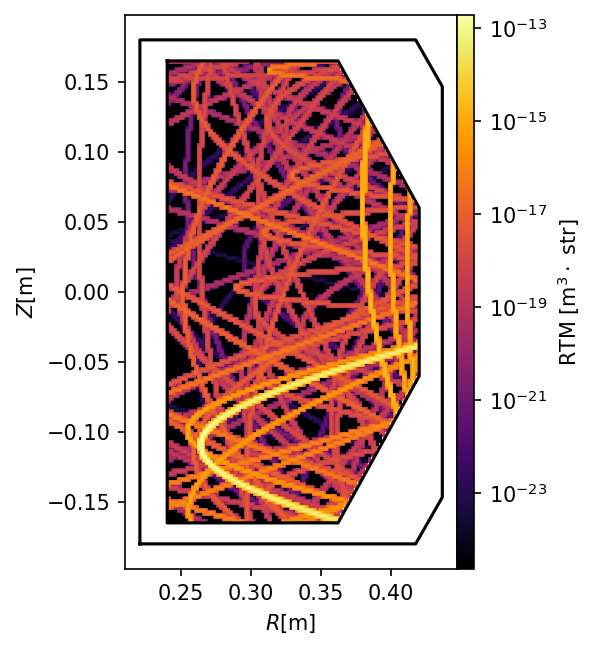

In [9]:
fig = plt.figure(dpi=150)
fig, axes = show_phix_profiles(
    rtm_profile,
    fig=fig,
    rtc=rtc,
    clabel="RTM [m$^3\\cdot$ str]",
    plot_mode="log",
    scientific_notation=False,
)

We can figure out that the highest values correspond to the trajectory which rays triggered from a pixel pass through.